# Alertness Machine Learning Model Training

In [2256]:
import mne
import re
from mne.preprocessing import ICA
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score

import seaborn as sns
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import os
import pandas as pd
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from mne.time_frequency import psd_array_welch
from mne.utils import use_log_level
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
mne.set_log_level('ERROR')

In [2290]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_feature_by_stage(df, night_id: str, feature_col: str):
    """
    可视化某一夜 (night_id) 下，不同睡眠阶段 (stage) 与特征列 (feature_col) 的分布关系
    """
    # 过滤对应 night_id 的数据
    sub_df = df[df['night_id'] == night_id]

    if sub_df.empty:
        print(f"No data found for night_id: {night_id}")
        return

    # 绘图
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=sub_df, x='stage', y=feature_col, palette='Set2')
    sns.stripplot(data=sub_df, x='stage', y=feature_col, color='black', alpha=0.3, size=3, jitter=0.2)
    plt.title(f"{feature_col} by Stage (night_id={night_id})")
    plt.xlabel("Sleep Stage")
    plt.ylabel(feature_col)
    plt.tight_layout()
    plt.show()


In [3162]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_feature_with_stage_by_time(full_df, night_id, feature_col, stride_sec=5):
    sleep_data = pd.read_csv(f"/Users/lejieliu/Documents/LucidDreamInduction/20_sleep_dataset/{night_id}_label.csv")
    df_feat = full_df[full_df['night_id'] == night_id].reset_index(drop=True)

    if feature_col not in df_feat.columns:
        print(f"Feature '{feature_col}' not found in DataFrame.")
        return

    sleep_data['Relative Time'] = ((sleep_data['Timestamp'] - sleep_data['Timestamp'].iloc[0]) / stride_sec).astype(int)

    end_time = max(len(df_feat), sleep_data['Relative Time'].max())

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 8), gridspec_kw={'height_ratios': [2, 1]})

    ax1.plot(df_feat[feature_col], color='red', label=feature_col)
    ax1.set_ylabel(f"{feature_col}")
    ax1.set_title(f"{feature_col} over Time — {night_id}")
    ax1.grid(True)
    ax1.legend(loc='upper right')

    stage_colors = {
        'Deep': 'blue',
        'Light': 'gold',
        'REM': 'green',
        'Wake': 'red'
    }

    for stage, color in stage_colors.items():
        stage_data = sleep_data[sleep_data['Sleep stage'] == stage]
        ax2.scatter(stage_data['Relative Time'], [stage] * len(stage_data), color=color, label=stage, s=10)

    ax2.set_xlabel(f"Time (index, stride = {stride_sec}s)")
    ax2.set_ylabel("Sleep Stage")
    ax2.legend(title='Sleep Stage', loc='upper right')
    ax2.grid(True)

    ax1.set_xlim(0, end_time)
    ax2.set_xlim(0, end_time)

    plt.tight_layout()
    plt.show()


In [3112]:
stage_to_score = {
    'Wake': 1,
    'REM': 0.3,
    'Light': 0.1,
    'Deep': 0
}

def get_soft_label(sleep_series, center_idx, radius=100, sigma=4.0):
    weights = []
    scores = []

    for offset in range(-radius, radius + 1):
        idx = center_idx + offset
        if 0 <= idx < len(sleep_series):
            stage = sleep_series.iloc[idx]
            if stage in stage_to_score:
                score = stage_to_score[stage]
                weight = np.exp(-0.5 * (offset / sigma)**2)
                scores.append(score * weight)
                weights.append(weight)

    if weights:
        return np.sum(scores) / np.sum(weights)
    else:
        return np.nan


In [3124]:
def extract_edf_file_to_npy_with_orp(file_path, orp_lookup_path):
    # import json

    # lookup = json.load(open(orp_lookup_path))
    # qs = {k: np.array(v) for k, v in lookup['quantiles'].items()}
    # b2o = {int(k): v for k, v in lookup['bin_orp'].items()}

    # def digitize_rank(value, thresholds):
    #     return np.searchsorted(thresholds, value)

    # def make_bin_id(ranks):
    #     return ranks[0]*1000 + ranks[1]*100 + ranks[2]*10 + ranks[3]

    # def four_band_power(psd, freqs):
    #     return np.array([
    #         psd[:, np.logical_and(freqs >= 0.3,  freqs < 2.3)].mean(),
    #         psd[:, np.logical_and(freqs >= 2.7,  freqs < 6.3)].mean(),
    #         psd[:, np.logical_and(freqs >= 7.3, freqs < 14.0)].mean(),
    #         psd[:, np.logical_and(freqs >= 14.3, freqs < 35.0)].mean(),
    #     ])

    match = re.search(r'night_\d+', file_path)
    night_id = match.group() if match else ''
    print(f'start process data for {night_id}')

    raw = mne.io.read_raw_edf(file_path, preload=True)
    raw.pick_channels(['RF-FpZ'])
    raw.filter(l_freq=0.5, h_freq=40)
    raw.notch_filter(freqs=60)

    sleep_file_path = file_path.replace('.edf', '_label.csv')
    sleep_data = pd.read_csv(sleep_file_path)
    sleep_series = sleep_data['Sleep stage'].reset_index(drop=True)

    sfreq = raw.info['sfreq']
    data = raw.get_data() 
    print(f"sfreq: {sfreq}")

    win_sec, step_sec = 15, 5
    n_win, n_step = int(win_sec * sfreq), int(step_sec * sfreq)

    raw_feats, label_list, stage_list = [], [], []

    for st in tqdm(range(0, data.shape[1] - n_win, n_step), desc="Extracting windows"):
        seg = data[:, st:st + n_win]
        psd, f = psd_array_welch(seg, sfreq, fmin=1, fmax=40, n_fft=n_win)
        idx = lambda lo, hi: np.logical_and(f >= lo, f < hi)

        epoch_idx = int((st / sfreq) // 30)
        if epoch_idx >= len(sleep_series):
            break
        

        delta = psd[:, idx(1, 4)].mean()
        theta = psd[:, idx(4, 8)].mean()
        alpha = psd[:, idx(8, 13)].mean()
        beta  = psd[:, idx(13, 30)].mean()
        gamma = psd[:, idx(30, 40)].mean()

        total = delta + theta + alpha + beta
        rel_delta = delta / total
        rel_theta = theta / total
        rel_alpha = alpha / total

        alpha_ratio = alpha / (alpha + theta + beta)
        theta_alpha_ratio = theta / alpha
        delta_theta_ratio = delta / theta
        beta_delta_ratio = beta / delta
        

        psd_flat = psd.flatten()
        psd_norm = psd_flat / psd_flat.sum()
        spec_entropy = -(psd_norm * np.log(psd_norm)).sum()

        sig = seg.flatten()
        var0 = np.var(sig)
        var1 = np.var(np.diff(sig))
        var2 = np.var(np.diff(np.diff(sig)))
        hj_mobility = np.sqrt(var1 / var0)
        hj_complexity = np.sqrt(var2 / var1)

        cumsum_psd = np.cumsum(psd_flat)
        sef95 = np.interp(cumsum_psd[-1] * 0.95, cumsum_psd, np.repeat(f, psd.shape[0]))

        arousal_intensity = beta / (delta)

 
        # n_3s = int(sfreq * 3)
        # orp_values = []
        # for k in range(0, seg.shape[1] - n_3s + 1, n_3s):
        #     sub_seg = seg[:, k:k+n_3s]
        #     sub_psd, freqs = psd_array_welch(sub_seg, sfreq=sfreq, fmin=1, fmax=40, n_fft=n_3s)
        #     bands = four_band_power(sub_psd, freqs)
        #     ranks = [digitize_rank(bands[j], qs[list(qs)[j]]) for j in range(4)]
        #     bin_id = make_bin_id(ranks)
        #     orp_val = b2o.get(bin_id, 1.25)
        #     orp_values.append(orp_val)
        # orp_mean = np.mean(orp_values)
        # orp_std = np.std(orp_values)
        # orp_range = np.ptp(orp_values)
        # orp_slop  = np.diff(orp_values).mean()
        # orp_cv = orp_std / (orp_mean + 1e-12)



        raw_feats.append([
            # delta, theta, alpha, beta, gamma,
            rel_delta, rel_theta, rel_alpha, 
            alpha_ratio, theta_alpha_ratio, delta_theta_ratio,
            beta_delta_ratio,
            spec_entropy, hj_mobility, hj_complexity, sef95,
            # orp_mean, orp_std, orp_range, orp_slop, orp_cv
        ])


        stage = sleep_series.iloc[epoch_idx]
        label = np.clip(get_soft_label(sleep_series, epoch_idx, radius=5), 0, 1)
        stage_list.append(stage)
        label_list.append(label)

    feature_names = [
        # 'delta', 'theta', 'alpha', 'beta', 'gamma',
    'rel_delta_power', 'rel_theta_power', 'rel_alpha_power',
    'alpha_ratio', 'theta_alpha_ratio', 'delta_theta_ratio',
    'beta_delta_ratio',
    'spectral_entropy', 'hjorth_mobility', 'hjorth_complexity', 'sef95',
    # 'orp_mean', 'orp_std', 'orp_range', 'orp_slope', 'orp_cv'
    ]

    df_feat = pd.DataFrame(raw_feats, columns=feature_names)

    for col in feature_names:
        df_feat[col] = df_feat[col].ewm(span=3, adjust=False).mean()

    df_feat['label'] = label_list
    df_feat['stage'] = stage_list
    print(f"Done preprocessing for {night_id}")
    return df_feat

In [3125]:
def extract_edf_file_to_npy(file_path):
    match = re.search(r'night_\d+', file_path)
    night_id = match.group() if match else ''
    print(f'start process data for {night_id}')

    raw = mne.io.read_raw_edf(file_path, preload=True)
    raw.pick_channels(['RF-FpZ'])
    raw.filter(l_freq=0.5, h_freq=40)
    raw.notch_filter(freqs=60)

    sleep_file_path = file_path.replace('.edf', '_label.csv')
    sleep_data = pd.read_csv(sleep_file_path)
    sleep_series = sleep_data['Sleep stage'].reset_index(drop=True)

    sfreq = raw.info['sfreq']
    data = raw.get_data() 
    print(f"sfreq: {sfreq}")

    win_sec, step_sec = 15, 5
    n_win, n_step = int(win_sec * sfreq), int(step_sec * sfreq)

    raw_feats, label_list, stage_list = [], [], []

    for st in tqdm(range(0, data.shape[1] - n_win, n_step), desc="Extracting windows"):
        seg = data[:, st:st + n_win]
        psd, f = psd_array_welch(seg, sfreq, fmin=1, fmax=40, n_fft=n_win)
        idx = lambda lo, hi: np.logical_and(f >= lo, f < hi)

        delta = psd[:, idx(1, 4)].mean()
        theta = psd[:, idx(4, 8)].mean()
        alpha = psd[:, idx(8, 13)].mean()
        beta  = psd[:, idx(13, 30)].mean()
        gamma = psd[:, idx(30, 40)].mean()

        total = delta + theta + alpha + beta + gamma
        rel_delta = delta / total
        rel_theta = theta / total
        rel_alpha = alpha / total
        rel_high  = (beta + gamma) / total
        beta_delta_ratio = beta / (delta)

        psd_flat = psd.flatten()
        psd_norm = psd_flat / psd_flat.sum()
        spec_entropy = -(psd_norm * np.log(psd_norm )).sum()

        sig = seg.flatten()
        var0 = np.var(sig)
        var1 = np.var(np.diff(sig))
        var2 = np.var(np.diff(np.diff(sig)))
        hj_mobility = np.sqrt(var1 / var0)
        hj_complexity = np.sqrt(var2 / var1)

        cumsum_psd = np.cumsum(psd_flat)
        sef95 = np.interp(cumsum_psd[-1] * 0.95, cumsum_psd, np.repeat(f, psd.shape[0]))

        arousal_intensity = beta / (delta)

        raw_feats.append([
            delta, theta, alpha, beta, gamma,
            rel_delta, rel_theta, rel_alpha, rel_high,
            beta_delta_ratio,
            spec_entropy, hj_mobility, hj_complexity, sef95,
            arousal_intensity
        ])

        epoch_idx = int((st / sfreq) // 30)
        if epoch_idx >= len(sleep_series):
            break

        stage = sleep_series.iloc[epoch_idx]
        label = np.clip(get_soft_label(sleep_series, epoch_idx, radius=2), 0, 1)
        stage_list.append(stage)
        label_list.append(label)

    # Create DataFrame and smooth each column
    feature_names = [
        'rel_delta', 'rel_theta', 'rel_alpha',
        'beta_delta_ratio',
        'spec_entropy', 'hjorth_mobility', 'hjorth_complexity', 'sef95',
        'arousal_intensity'
    ]

    df_feat = pd.DataFrame(raw_feats, columns=feature_names)

    # Apply EMA smoothing
    for col in feature_names:
        df_feat[col] = df_feat[col].ewm(span=3, adjust=False).mean()

    df_feat['label'] = label_list
    df_feat['stage'] = stage_list

    df_feat.to_csv(f'/Users/lejieliu/Documents/LucidDreamInduction/processed_data/{night_id}_processed.csv', index=False)

    print(f"Done preprocessing for {night_id}")
    return df_feat


In [3126]:
def batch_extract_all_edfs(data_dir):

    lookup_dir = '/Users/lejieliu/Documents/LucidDreamInduction/20_sleep_dataset/orp_lookup.json'
    edf_files = sorted(glob(os.path.join(data_dir, "*.edf")))

    all_dfs = []

    for edf_path in tqdm(edf_files, desc="Processing EDF files"):
        try:
            night_id = os.path.basename(edf_path).replace('.edf', '')
            # if night_id in ['night_03', 'night_05', 'night_06', 'night_08', 'night_09', 'night_10', 'night_11', 'night_12', 'night_13', 'night_17', 'night_18', 'night_19']:
            #     continue
            
            df = extract_edf_file_to_npy_with_orp(edf_path, lookup_dir)
            
            
            df['night_id'] = night_id
            print(f'working on {night_id}')

            all_dfs.append(df)

        except Exception as e:
            print(f" Failed to process {edf_path}: {e}")

    full_df = pd.concat(all_dfs, ignore_index=True)
    return full_df

In [3127]:
data_dir = '/Users/lejieliu/Documents/LucidDreamInduction/20_sleep_dataset'
full_df = batch_extract_all_edfs(data_dir)

Processing EDF files:   0%|                              | 0/16 [00:00<?, ?it/s]

start process data for night_01
sfreq: 125.0


Processing EDF files:   6%|█▍                    | 1/16 [00:05<01:20,  5.36s/it]

Done preprocessing for night_01
working on night_01
start process data for night_02
sfreq: 125.0


Processing EDF files:  12%|██▊                   | 2/16 [00:08<00:59,  4.25s/it]

Done preprocessing for night_02
working on night_02
start process data for night_04
sfreq: 125.0


Processing EDF files:  19%|████▏                 | 3/16 [00:14<01:03,  4.91s/it]

Done preprocessing for night_04
working on night_04
start process data for night_05
sfreq: 125.0


Processing EDF files:  25%|█████▌                | 4/16 [00:19<00:58,  4.89s/it]

Done preprocessing for night_05
working on night_05
start process data for night_06
sfreq: 125.0


Processing EDF files:  31%|██████▉               | 5/16 [00:22<00:48,  4.39s/it]

Done preprocessing for night_06
working on night_06
start process data for night_07
sfreq: 125.0


Processing EDF files:  38%|████████▎             | 6/16 [00:28<00:46,  4.66s/it]

Done preprocessing for night_07
working on night_07
start process data for night_09
sfreq: 125.0


Processing EDF files:  44%|█████████▋            | 7/16 [00:35<00:49,  5.51s/it]

Done preprocessing for night_09
working on night_09
start process data for night_10
sfreq: 125.0


Processing EDF files:  50%|███████████           | 8/16 [00:43<00:49,  6.21s/it]

Done preprocessing for night_10
working on night_10
start process data for night_11
sfreq: 125.0


Processing EDF files:  56%|████████████▍         | 9/16 [00:48<00:41,  5.97s/it]

Done preprocessing for night_11
working on night_11
start process data for night_12
sfreq: 125.0


Processing EDF files:  62%|█████████████▏       | 10/16 [00:54<00:35,  5.90s/it]

Done preprocessing for night_12
working on night_12
start process data for night_13
sfreq: 125.0


Processing EDF files:  69%|██████████████▍      | 11/16 [01:00<00:30,  6.11s/it]

Done preprocessing for night_13
working on night_13
start process data for night_14
sfreq: 125.0


Processing EDF files:  75%|███████████████▊     | 12/16 [01:07<00:24,  6.22s/it]

Done preprocessing for night_14
working on night_14
start process data for night_15
sfreq: 125.0


Processing EDF files:  81%|█████████████████    | 13/16 [01:14<00:19,  6.39s/it]

Done preprocessing for night_15
working on night_15
start process data for night_16
sfreq: 125.0


Processing EDF files:  88%|██████████████████▍  | 14/16 [01:21<00:13,  6.78s/it]

Done preprocessing for night_16
working on night_16
start process data for night_18
sfreq: 125.0


Processing EDF files:  94%|███████████████████▋ | 15/16 [01:26<00:06,  6.11s/it]

Done preprocessing for night_18
working on night_18
start process data for night_20
sfreq: 125.0


Processing EDF files: 100%|█████████████████████| 16/16 [01:32<00:00,  5.79s/it]

Done preprocessing for night_20
working on night_20


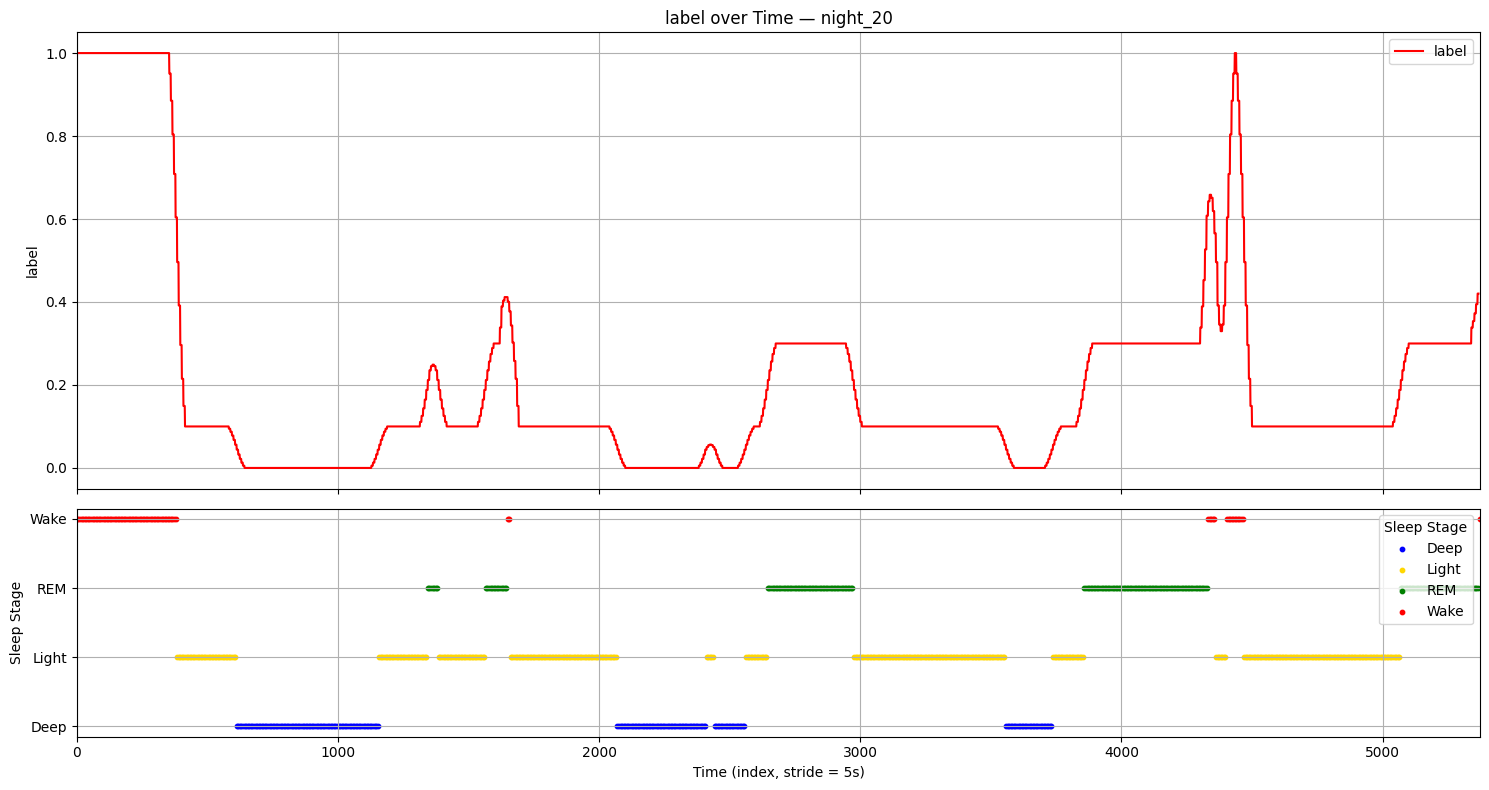

In [3169]:
plot_feature_with_stage_by_time(full_df, night_id="night_20", feature_col="label", stride_sec=5)

In [2809]:
full_df = full_df[full_df['night_id'] != 'night_01']

In [3129]:
full_df.to_csv('/Users/lejieliu/Documents/LucidDreamInduction/processed_data/all_nights.csv', index=False)

In [3028]:
full_df = pd.read_csv('/Users/lejieliu/Documents/LucidDreamInduction/processed_data/all_nights.csv')

In [3130]:
feature_cols = [col for col in full_df.columns if col not in ['label', 'night_id', 'stage','stage_id']]


In [3034]:
all_features = [
    'rel_delta_power',
    'rel_theta_power',
    'rel_alpha_power',
    'alpha_ratio',
    'theta_alpha_ratio',
    'delta_theta_ratio',
    'beta_delta_ratio',
    'spectral_entropy',
    'hjorth_mobility',
    'hjorth_complexity',
    'sef95',
    'orp_mean',
    'orp_std',
    'orp_range',
    'orp_slope',
    'orp_cv'
]

In [3031]:
features_to_remove = [
    'beta_delta_ratio',
    'alpha_ratio',
    'rel_alpha_power',
    'hjorth_mobility',
    'hjorth_complexity',
    
]

In [3032]:
feature_cols = [f for f in all_features if f not in features_to_remove]

In [3131]:
feature_cols

['rel_delta_power',
 'rel_theta_power',
 'rel_alpha_power',
 'alpha_ratio',
 'theta_alpha_ratio',
 'delta_theta_ratio',
 'beta_delta_ratio',
 'spectral_entropy',
 'hjorth_mobility',
 'hjorth_complexity',
 'sef95',
 'orp_mean',
 'orp_std',
 'orp_range',
 'orp_slope',
 'orp_cv']

In [3132]:
train_feature_cols = feature_cols

In [3133]:
full_df.columns

Index(['rel_delta_power', 'rel_theta_power', 'rel_alpha_power', 'alpha_ratio',
       'theta_alpha_ratio', 'delta_theta_ratio', 'beta_delta_ratio',
       'spectral_entropy', 'hjorth_mobility', 'hjorth_complexity', 'sef95',
       'orp_mean', 'orp_std', 'orp_range', 'orp_slope', 'orp_cv', 'label',
       'stage', 'night_id'],
      dtype='object')

In [3134]:
full_df_copy = full_df.copy()

In [3223]:
full_df = full_df[full_df['stage'].isin(['Wake', 'Deep'])]

In [3222]:
stage_map = {'Wake':0, 'REM':2, 'Light':3, 'Deep':1}
full_df['stage_id'] = full_df['stage'].map(stage_map)
full_df_copy['stage_id'] = full_df_copy['stage'].map(stage_map)
# full_df = full_df.dropna(subset=['stage_id']).reset_index(drop=True)

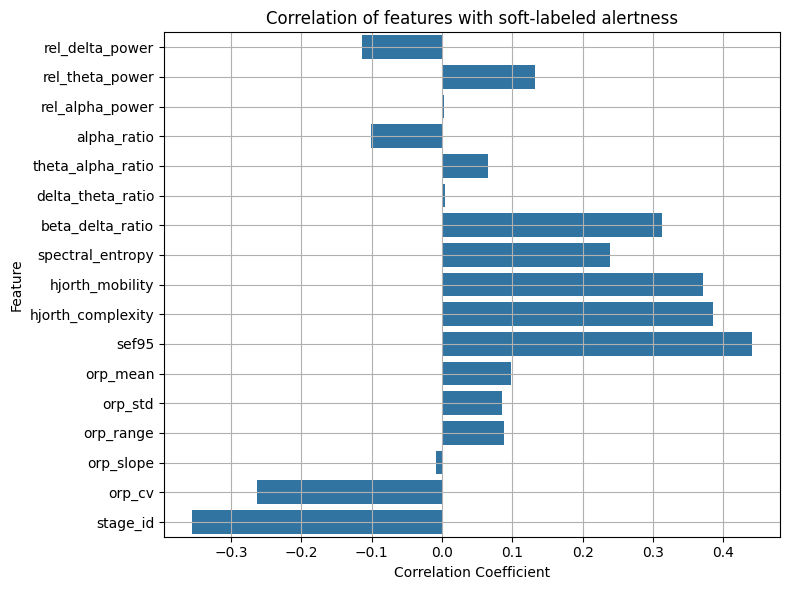

In [3246]:
numeric_df = full_df_copy.select_dtypes(include='number')
correlation_matrix = numeric_df.corr(method = 'pearson')
label_name = 'label'  # 替换为你的实际 label 列名
corr_with_label = correlation_matrix[label_name].drop(label_name)  # 排除自身

# 可视化
plt.figure(figsize=(8, 6))
sns.barplot(x=corr_with_label.values, y=corr_with_label.index)
plt.title(f"Correlation of features with soft-labeled alertness")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.grid(True)
plt.tight_layout()
plt.show()

# Training Process

In [3247]:
full_df = full_df.dropna().reset_index(drop=True)

In [3248]:
target = 'label'
# target = 'stage_id'

nights = full_df['night_id'].unique()
train_ids, valtest_ids = train_test_split(nights, test_size=0.3, random_state=42)
val_ids, test_ids = train_test_split(valtest_ids, test_size=0.1, random_state=42)

df_train = full_df[full_df['night_id'].isin(train_ids)]
df_val   = full_df[full_df['night_id'].isin(val_ids)]
df_test  = full_df[full_df['night_id'].isin(test_ids)]

print("train nights:", sorted(train_ids))
print("Val  nights:", sorted(val_ids))
print("Test nights:", sorted(test_ids))

X_tr = df_train[feature_cols].values
y_tr = df_train[target].values

X_val = df_val[feature_cols].values
y_val = df_val[target].values

X_test = df_test[feature_cols].values
y_test = df_test[target].values

train nights: ['night_04', 'night_05', 'night_06', 'night_09', 'night_10', 'night_11', 'night_12', 'night_13', 'night_14', 'night_15', 'night_20']
Val  nights: ['night_01', 'night_07', 'night_16', 'night_18']
Test nights: ['night_02']


# Classification Model

In [741]:
bins = [0.0, 0.2, 0.4, 0.7, 1.0]

In [ ]:
lgb_reg = lgb.LGBMRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=64,
    objective='regression'
)
lgb_reg.fit(X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            eval_metric='l2'
            )
print("Val R²:", lgb_reg.score(X_val, y_val))

y_val_pred = lgb_reg.predict(X_val)



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4845
[LightGBM] [Info] Number of data points in the train set: 14122, number of used features: 19
[LightGBM] [Info] Start training from score 0.838691
Val R²: 0.290193974065754


/opt/anaconda3/envs/frenz-env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/frenz-env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [2350]:
# 基本回归指标
y_val_pred = lgb_reg.predict(X_val)
r2   = r2_score(y_val, y_val_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
mae  = mean_absolute_error(y_val, y_val_pred)
evs  = explained_variance_score(y_val, y_val_pred)
from scipy.stats import spearmanr

rho, p = spearmanr(y_val, y_val_pred)
print("Spearman rank correlation:", rho)

print(f"Validation R²   : {r2:.3f}")
print(f"Validation RMSE : {rmse:.4f}")
print(f"Validation MAE  : {mae:.4f}")
print(f"Explained Var   : {evs:.3f}")

/opt/anaconda3/envs/frenz-env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


ValueError: X has 15 features, but LGBMRegressor is expecting 19 features as input.

In [3227]:
lgb_clf = lgb.LGBMClassifier(
    n_estimators=400,
    objective='binary',
    class_weight={0: 5, 1: 1},
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.8,
    num_leaves=64,
    random_state=42,
    reg_alpha=1.0,
    reg_lambda=1.0
)

lgb_clf.fit(
    X_tr, y_tr,  
    eval_set=[(X_val, y_val)],
    eval_metric='f1',
    # sample_weight=sample_weight
)


[LightGBM] [Info] Number of positive: 13404, number of negative: 3387
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 16791, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.441808 -> initscore=-0.233829
[LightGBM] [Info] Start training from score -0.233829


LGBMClassifier(class_weight={0: 5, 1: 1}, learning_rate=0.05, n_estimators=400,
               num_leaves=64, objective='binary', random_state=42,
               reg_alpha=1.0, reg_lambda=1.0, subsample=0.8)

In [3228]:

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

label_names = ['Wake', 'Deep']
y_val_pred = lgb_clf.predict_proba(X_val)
y_pred_class = np.argmax(y_val_pred, axis=1)

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_val, y_pred_class, digits=3,target_names=label_names))
print(confusion_matrix(y_val, y_pred_class))

              precision    recall  f1-score   support

        Wake      0.611     0.663     0.636       996
        Deep      0.937     0.923     0.930      5460

    accuracy                          0.883      6456
   macro avg      0.774     0.793     0.783      6456
weighted avg      0.887     0.883     0.885      6456

[[ 660  336]
 [ 421 5039]]


/opt/anaconda3/envs/frenz-env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [3231]:
model = lgb_clf
# model = cali_model

from sklearn.metrics import (
    roc_auc_score, average_precision_score, matthews_corrcoef,
    brier_score_loss, log_loss, cohen_kappa_score
)

y_pred_proba = model.predict_proba(X_val)[:, 1]
y_pred = model.predict(X_val)

print("ROC AUC:", roc_auc_score(y_val, y_pred_proba))
print("PR AUC:", average_precision_score(y_val, y_pred_proba))
print("MCC:", matthews_corrcoef(y_val, y_pred))
print("Brier Score:", brier_score_loss(y_val, y_pred_proba))
print("Log Loss:", log_loss(y_val, y_pred_proba))
print("Cohen's Kappa:", cohen_kappa_score(y_val, y_pred))

ROC AUC: 0.9109108595554378
PR AUC: 0.9811912853353123
MCC: 0.5664788801312663
Brier Score: 0.08919565449643589
Log Loss: 0.31644416645435475
Cohen's Kappa: 0.5658052410499157


/opt/anaconda3/envs/frenz-env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/frenz-env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [2895]:
def custom_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    entropy = -y_pred * tf.math.log(y_pred + 1e-7) - (1 - y_pred) * tf.math.log(1 - y_pred + 1e-7)
    return bce + 0.05 * entropy

In [3259]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report

scaler = StandardScaler()
X_tr_std  = scaler.fit_transform(X_tr)
X_val_std = scaler.transform(X_val)
X_test_std= scaler.transform(X_test)

def build_mlp(input_dim: int,
              hidden_units=(128, 64, 32),
              dropout=0.3) -> tf.keras.Model:
    inp = layers.Input(shape=(input_dim,))
    x   = inp
    for h in hidden_units:
        x = layers.Dense(h, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout)(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    return models.Model(inp, out)

model = build_mlp(input_dim=X_tr_std.shape[1])

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['mse','mae']
)

early_stop = callbacks.EarlyStopping(
    monitor='val_auc',      
    patience=10,
    mode='max',
    restore_best_weights=True
)

history = model.fit(
    X_tr_std, y_tr,
    validation_data=(X_val_std, y_val),
    epochs=200,
    batch_size=1024,
    callbacks=[early_stop],
    verbose=2
)

model.save("sleep_mlp_classifier.h5")


Epoch 1/200
55/55 - 1s - 14ms/step - loss: 0.7139 - mae: 0.3347 - mse: 0.1557 - val_loss: 0.5467 - val_mae: 0.2906 - val_mse: 0.0963
Epoch 2/200
55/55 - 0s - 3ms/step - loss: 0.5670 - mae: 0.2582 - mse: 0.0957 - val_loss: 0.4571 - val_mae: 0.2059 - val_mse: 0.0568
Epoch 3/200


/opt/anaconda3/envs/frenz-env/lib/python3.9/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: loss,mae,mse,val_loss,val_mae,val_mse
  current = self.get_monitor_value(logs)


55/55 - 0s - 4ms/step - loss: 0.4942 - mae: 0.2015 - mse: 0.0661 - val_loss: 0.4132 - val_mae: 0.1610 - val_mse: 0.0398
Epoch 4/200
55/55 - 0s - 3ms/step - loss: 0.4512 - mae: 0.1602 - mse: 0.0493 - val_loss: 0.3841 - val_mae: 0.1243 - val_mse: 0.0307
Epoch 5/200
55/55 - 0s - 3ms/step - loss: 0.4319 - mae: 0.1365 - mse: 0.0422 - val_loss: 0.3772 - val_mae: 0.1141 - val_mse: 0.0289
Epoch 6/200
55/55 - 0s - 3ms/step - loss: 0.4229 - mae: 0.1252 - mse: 0.0389 - val_loss: 0.3739 - val_mae: 0.1066 - val_mse: 0.0281
Epoch 7/200
55/55 - 0s - 3ms/step - loss: 0.4161 - mae: 0.1188 - mse: 0.0370 - val_loss: 0.3714 - val_mae: 0.1031 - val_mse: 0.0279
Epoch 8/200
55/55 - 0s - 3ms/step - loss: 0.4104 - mae: 0.1154 - mse: 0.0355 - val_loss: 0.3723 - val_mae: 0.1002 - val_mse: 0.0276
Epoch 9/200
55/55 - 0s - 3ms/step - loss: 0.4066 - mae: 0.1124 - mse: 0.0345 - val_loss: 0.3698 - val_mae: 0.1009 - val_mse: 0.0271
Epoch 10/200
55/55 - 0s - 3ms/step - loss: 0.4048 - mae: 0.1110 - mse: 0.0339 - val_loss

PermutationExplainer explainer: 1001it [00:56, 14.56it/s]                       
/var/folders/68/l7xp6fns3w92gfhrl5cn9x940000gn/T/ipykernel_9077/1777936317.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, features=X_val_std[:1000], feature_names=feature_cols)


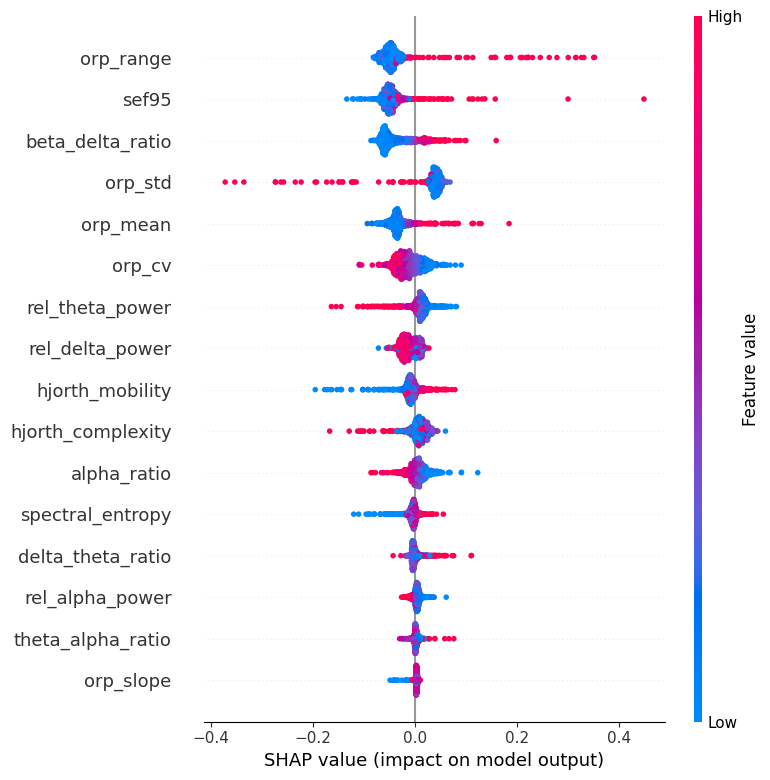

In [3174]:
import shap

explainer = shap.Explainer(model, X_val_std)
shap_values = explainer(X_val_std[:1000])  # 可选择一个子集

shap.summary_plot(shap_values, features=X_val_std[:1000], feature_names=feature_cols)


In [3260]:
X_test_std = scaler.transform(X_test)
val_pred = model.predict(X_test_std, batch_size=2048).ravel()
mse  = mean_squared_error(y_test, val_pred)
mae  = mean_absolute_error(y_test, val_pred)
r2   = r2_score(y_test, val_pred)
rmse = np.sqrt(mse)

print(f"Validation MAE:  {mae:.4f}")
print(f"Validation RMSE: {rmse:.4f}")
print(f"Validation R²:   {r2:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Validation MAE:  0.1136
Validation RMSE: 0.1846
Validation R²:   0.2580


In [3237]:
joblib.dump(scaler, '/Users/lejieliu/Documents/LucidDreamInduction/models/RandomState42_MLP_scaler.pkl')

['/Users/lejieliu/Documents/LucidDreamInduction/models/RandomState42_MLP_scaler.pkl']

In [3243]:
X_val_std = scaler.transform(X_val)
val_pred = model.predict(X_val_std, batch_size=2048).ravel()
mse  = mean_squared_error(y_val, val_pred)
mae  = mean_absolute_error(y_val, val_pred)
r2   = r2_score(y_val, val_pred)
rmse = np.sqrt(mse)

print(f"Validation MAE:  {mae:.4f}")
print(f"Validation RMSE: {rmse:.4f}")
print(f"Validation R²:   {r2:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Validation MAE:  0.1358
Validation RMSE: 0.2940
Validation R²:   0.3374


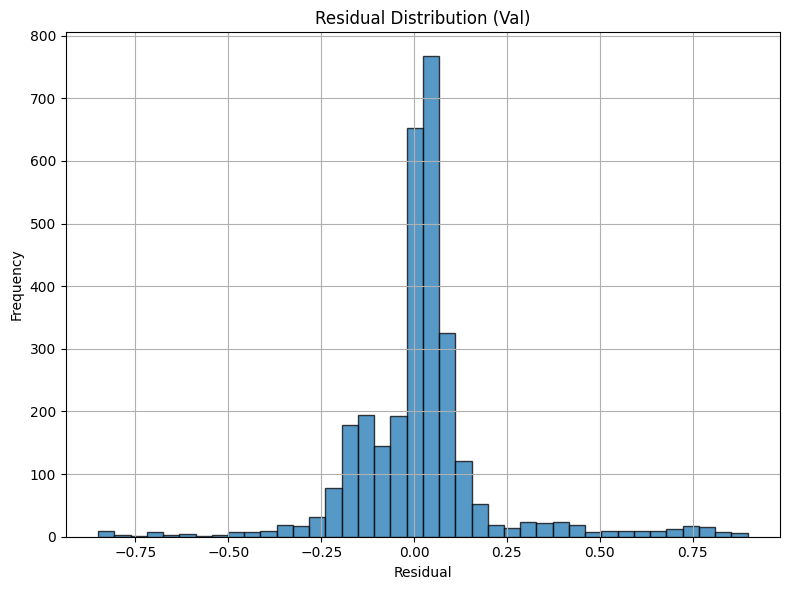

In [3158]:
residuals = val_pred - y_test

plt.figure(figsize=(8,6))
plt.hist(residuals, bins=40, alpha=0.75, edgecolor='k')
plt.title("Residual Distribution (Val)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

In [3160]:
from scipy.stats import spearmanr, kendalltau

print("Spearman R:", spearmanr(y_test, val_pred).correlation)
print("Kendall Tau:", kendalltau(y_test, val_pred).correlation)


Spearman R: 0.7629158233977708
Kendall Tau: 0.5873781218991185


In [2943]:
print(classification_report(y_val, val_pred, digits=3,target_names=label_names))

              precision    recall  f1-score   support

        Wake      0.524     0.655     0.582       996
        Deep      0.934     0.892     0.912      5460

    accuracy                          0.855      6456
   macro avg      0.729     0.773     0.747      6456
weighted avg      0.871     0.855     0.861      6456



In [1800]:
import joblib
joblib.dump(lgb_clf, '/Users/lejieliu/Documents/LucidDreamInduction/models/lgb_classifier_larger.pkl')

['/Users/lejieliu/Documents/LucidDreamInduction/models/lgb_classifier_larger.pkl']

In [2754]:
import pandas as pd
feat_imp = pd.DataFrame({"feature": feature_cols,
                         "importance": lgb_clf.feature_importances_})
print(feat_imp.sort_values("importance", ascending=False).head(50))

             feature  importance
3  theta_alpha_ratio        5274
7          orp_slope        5200
6          orp_range        5151
5           orp_mean        4979
2    rel_alpha_power        4425
4  delta_theta_ratio        4356
0    rel_delta_power        4319
1    rel_theta_power        4096


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Pred mean: 0.18625546
Pred std: 0.20052949
REM Period Mean EMA Alertness: 0.2216
Wake: Mean Predicted Alertness = 0.573
REM: Mean Predicted Alertness = 0.222
Light: Mean Predicted Alertness = 0.140
Deep: Mean Predicted Alertness = 0.094


/opt/anaconda3/envs/frenz-env/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


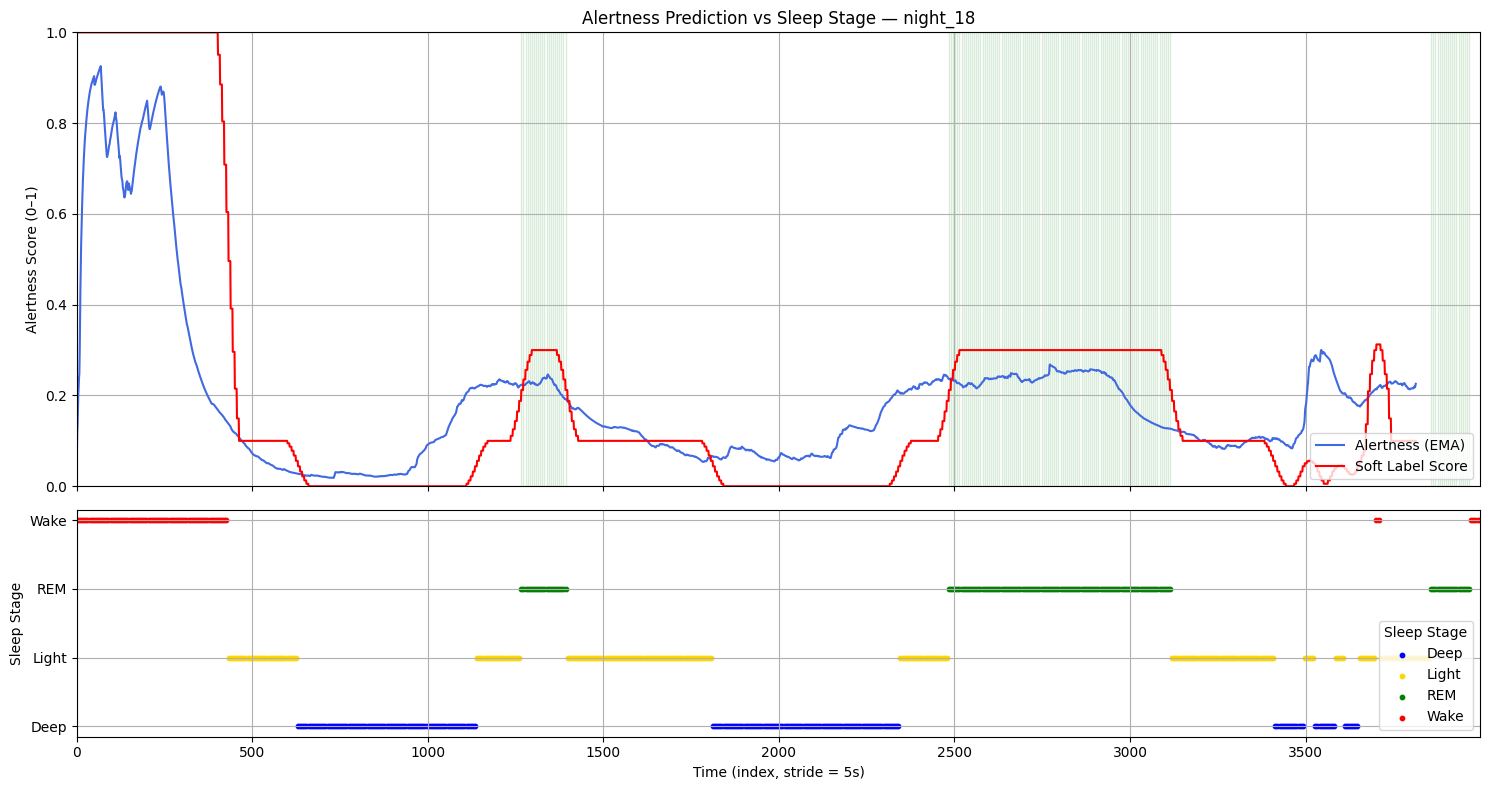

In [3271]:
visualize_predict_result(full_df_copy, "night_18",ema_span=50, start_time=0, end_time=None, model = model, stride_sec=5, clf = True, scaler= scaler)

In [3256]:
def visualize_predict_result(full_df, night_id, start_time=0, end_time=None, model=lgb_reg, ema_span=10, stride_sec=1, clf = False, scaler = None):
    sleep_data = pd.read_csv(f"/Users/lejieliu/Documents/LucidDreamInduction/20_sleep_dataset/{night_id}_label.csv")
    df_feat = full_df[full_df['night_id'] == night_id].reset_index(drop=True)
    
    feature_cols = train_feature_cols

    if scaler is not None:
        X = scaler.transform(df_feat[feature_cols])
    else:
        X = df_feat[feature_cols].values

    if clf:
        if scaler:
            df_feat['alert_pred'] = model.predict(X, batch_size = 2048)
        else:
            temp = model.predict_proba(X)
            df_feat['alert_pred'] = temp[:, 0] * 1
    else:
        df_feat['alert_pred'] = model.predict(X)



    df_feat['alert_pred_ema'] = df_feat['alert_pred'].ewm(ema_span).mean()

    print("Pred mean:", df_feat['alert_pred'].mean())
    print("Pred std:", df_feat['alert_pred'].std())

    # 时间对齐：把标签数据从秒数单位 -> stride 下标单位
    sleep_data['Relative Time'] = ((sleep_data['Timestamp'] - sleep_data['Timestamp'].iloc[0]) / stride_sec).astype(int)

    rem_times = sleep_data[sleep_data['Sleep stage'] == 'REM']['Relative Time'].values
    rem_times = rem_times[rem_times < len(df_feat)]  # 避免越界

    rem_alertness_ema = df_feat.loc[rem_times, 'alert_pred_ema']
    rem_threshold = rem_alertness_ema.mean()

    print(f"REM Period Mean EMA Alertness: {rem_threshold:.4f}")

    # 自动计算时间范围（单位是 stride 索引）
    if end_time is None:
        end_time = max(len(df_feat), sleep_data['Relative Time'].max())

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 8), gridspec_kw={'height_ratios': [2, 1]})

    # ==== 上图: Alertness ====
    # ax1.axhline(y=rem_threshold, color='orange', linestyle='--', label='REM Mean Threshold')
    ax1.plot(df_feat['alert_pred_ema'], linestyle='-', color='royalblue', label='Alertness (EMA)')

    ax1.plot(df_feat['label'], linestyle='-', color='red', label='Soft Label Score')
    ax1.set_ylabel("Alertness Score (0–1)")
    ax1.set_title(f"Alertness Prediction vs Sleep Stage — {night_id}")
    ax1.set_ylim(0, 1)
    ax1.grid(True)
    ax1.legend(loc='lower right')

    # ==== 下图: Sleep Stage ====
    stage_colors = {
        'Deep': 'blue',
        'Light': 'gold',
        'REM': 'green',
        'Wake': 'red'
    }

    for stage, color in stage_colors.items():
        stage_data = sleep_data[sleep_data['Sleep stage'] == stage]
        ax2.scatter(stage_data['Relative Time'], [stage] * len(stage_data), color=color, label=stage, s=10)

    ax2.set_xlabel(f"Time (index, stride = {stride_sec}s)")
    ax2.set_ylabel("Sleep Stage")
    ax2.legend(title='Sleep Stage', loc='lower right')
    ax2.grid(True)

    ax1.set_xlim(start_time, end_time)
    ax2.set_xlim(start_time, end_time)

    # ==== 高亮 REM 区域 ====
    rem_data = sleep_data[sleep_data['Sleep stage'] == 'REM']
    rem_indices = rem_data['Relative Time'].values

    if len(rem_indices) > 0:
        gap_threshold = 5 // stride_sec  # 原本以“秒”为单位，这里要换成 index 间隔
        group_start = rem_indices[0]
        prev = rem_indices[0]

        for t in rem_indices[1:]:
            if t - prev > gap_threshold:
                ax1.axvspan(group_start, prev, color='green', alpha=0.15)
                group_start = t
            prev = t
        ax1.axvspan(group_start, prev, color='green', alpha=0.15)

    for stage in ['Wake', 'REM', 'Light', 'Deep']:
        rel_times = sleep_data[sleep_data['Sleep stage'] == stage]['Relative Time'].values
        rel_times = rel_times[rel_times < len(df_feat)]
        avg_alert = df_feat.loc[rel_times, 'alert_pred_ema'].mean()
        print(f"{stage}: Mean Predicted Alertness = {avg_alert:.3f}")
    plt.tight_layout()
    plt.show()


In [2604]:
import joblib
joblib.dump(lgb_reg, '/Users/lejieliu/Documents/LucidDreamInduction/models/large_lgb_model.pkl')

['/Users/lejieliu/Documents/LucidDreamInduction/models/large_lgb_model.pkl']

# Validation on Model

In [3177]:
import pandas as pd
import os

def get_all_night_predictions(night_list, full_df, model, feature_cols, scaler=None, clf=True, stride_sec=1, ema_span=10):
    all_result_rows = []

    for night_id in night_list:
        # 加载标签
        sleep_path = f"/Users/lejieliu/Documents/LucidDreamInduction/20_sleep_dataset/{night_id}_label.csv"
        sleep_data = pd.read_csv(sleep_path)

        # 取出特征
        df_feat = full_df[full_df['night_id'] == night_id].reset_index(drop=True)
        if scaler is not None:
            X = scaler.transform(df_feat[feature_cols])
        else:
            X = df_feat[feature_cols].values

        if clf:
            if scaler:
                df_feat['alert_pred'] = model.predict(X, batch_size = 2048)
            else:
                temp = model.predict_proba(X)
                df_feat['alert_pred'] = temp[:, 0] * 1
        else:
            df_feat['alert_pred'] = model.predict(X)

        df_feat['alert_pred_ema'] = df_feat['alert_pred'].ewm(ema_span).mean()

        # 时间对齐
        sleep_data['Relative Time'] = ((sleep_data['Timestamp'] - sleep_data['Timestamp'].iloc[0]) / stride_sec).astype(int)
        df_feat['stage'] = None
        for i, row in sleep_data.iterrows():
            if row['Relative Time'] < len(df_feat):
                df_feat.at[row['Relative Time'], 'stage'] = row['Sleep stage']

        df_feat['night_id'] = night_id
        all_result_rows.append(df_feat[['night_id', 'alert_pred', 'alert_pred_ema', 'stage']])

    # 合并所有夜晚的结果
    df_result = pd.concat(all_result_rows, ignore_index=True)
    df_result = df_result.dropna(subset=['stage'])  # 去掉无 stage 的点
    return df_result


In [3200]:
val_ids

array(['night_16', 'night_07', 'night_01', 'night_18'], dtype=object)

In [3201]:
all_nights = ['night_16', 'night_07', 'night_01', 'night_18', 'night_02']

df_result = get_all_night_predictions(
    night_list=all_nights,
    full_df=full_df_copy,
    model=model,
    feature_cols=train_feature_cols,
    scaler=scaler,
    clf=True,
    stride_sec=5,
    ema_span=30
)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/anaconda3/envs/frenz-env/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/frenz-env/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/frenz-env/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/frenz-env/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/frenz-env/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [3202]:
# 移除 sleep stage 为 'undefined' 的行
df_result = df_result[df_result['stage'] != 'Undefined']


/var/folders/68/l7xp6fns3w92gfhrl5cn9x940000gn/T/ipykernel_9077/438774175.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='stage', y='alert_pred', data=df_result, palette='muted')


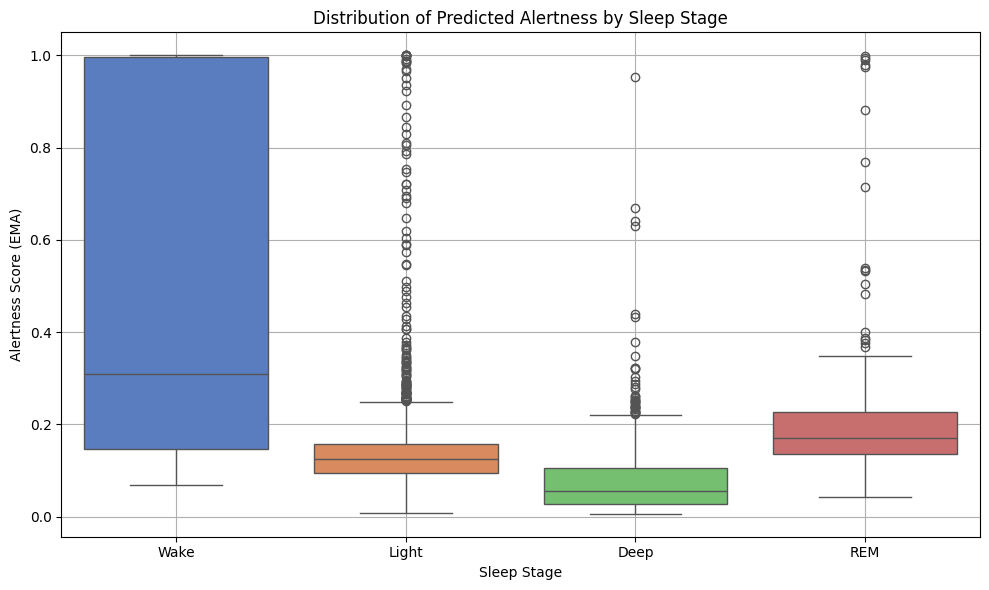

In [3203]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot 替代 violinplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='stage', y='alert_pred', data=df_result, palette='muted')
plt.title('Distribution of Predicted Alertness by Sleep Stage')
plt.ylabel('Alertness Score (EMA)')
plt.xlabel('Sleep Stage')
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/68/l7xp6fns3w92gfhrl5cn9x940000gn/T/ipykernel_9077/4119705480.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='stage', y='alert_pred', data=df_result, palette='muted', inner='box')


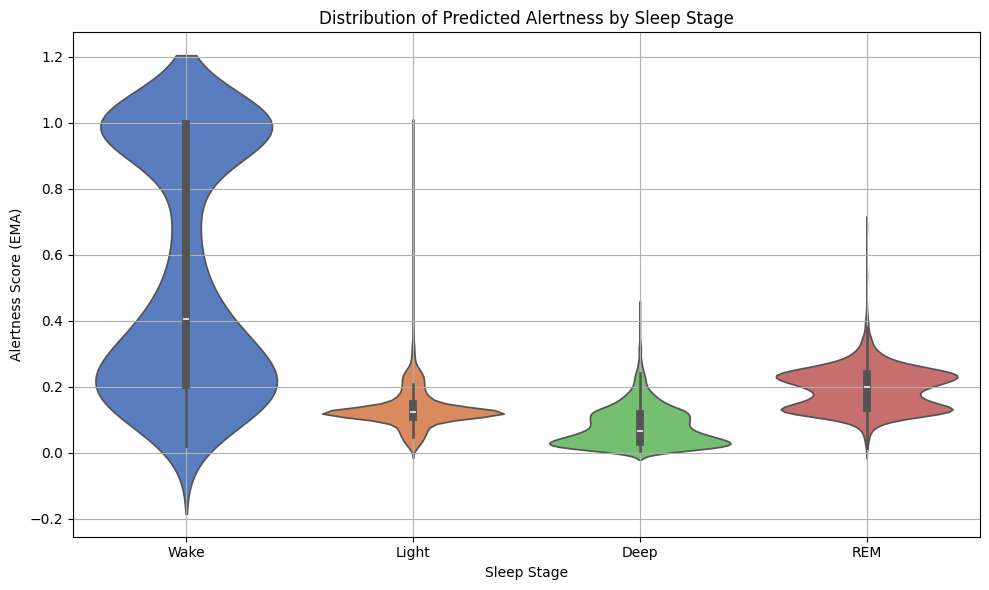

In [3191]:
import seaborn as sns
import matplotlib.pyplot as plt

# 使用 violinplot
plt.figure(figsize=(10, 6))
sns.violinplot(x='stage', y='alert_pred', data=df_result, palette='muted', inner='box')
plt.title('Distribution of Predicted Alertness by Sleep Stage')
plt.ylabel('Alertness Score (EMA)')
plt.xlabel('Sleep Stage')
plt.grid(True)
plt.tight_layout()
plt.show()

In [3192]:
for stage in ['Wake', 'REM', 'Light', 'Deep']:
    stage_values = df_result[df_result['stage'] == stage]['alert_pred']
    print(f"{stage}: mean={stage_values.mean():.3f}, std={stage_values.std():.3f}")

Wake: mean=0.550, std=0.363
REM: mean=0.194, std=0.064
Light: mean=0.134, std=0.060
Deep: mean=0.080, std=0.059
